## Importing libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import time
from datetime import date, timedelta, datetime
import pandas_gbq
from google.cloud import bigquery
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import math

from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
import gc
warnings.filterwarnings('ignore')
collected_objects = gc.collect()

/opt/conda/lib/python3.7/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [2]:
os.environ["http_proxy"] = "http://geoproxy.kohls.com:3128"
os.environ["HTTP_PROXY"] = "http://geoproxy.kohls.com:3128"
os.environ["https_proxy"] = "http://geoproxy.kohls.com:3128"
os.environ["HTTPS_PROXY"] = "http://geoproxy.kohls.com:3128"

client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

del os.environ['http_proxy']
del os.environ['HTTP_PROXY']
del os.environ['https_proxy']
del os.environ['HTTPS_PROXY']

os.chdir('/home/jupyter/SalesForecasting/GmWorkingData/Unsubscribe_email')

Client creating using default project: kohls-bda-mkt-lle


## Data Ingestion

In [3]:
t1 = time.time()
## qr = '''SELECT * FROM kohls-bda-mkt-prd.dp_marketing_sandbox.TKA1JB1_for_email_unsubsribe_data1'''
# qr = '''SELECT * FROM kohls-bda-mkt-prd.dp_marketing_sandbox.TKA1JB1_email_unsubscribe_v3_OOS'''
qr = '''SELECT * FROM kohls-bda-mkt-prd.dp_marketing_sandbox.TKA1JB1_email_unsubscribe_v3_train_OOS_2'''
training_data_m= pandas_gbq.read_gbq(qr,project_id='kohls-bda-mkt-lle',use_bqstorage_api=True)
print(f"Total time taken to read the data : {(time.time()-t1)/60} mins")
# final_data = final_data.drop_duplicates()

Downloading: 100%|██████████|
Total time taken to read the data : 3.89317520459493 mins


In [4]:
t1 = time.time()
## qr = '''SELECT * FROM kohls-bda-mkt-prd.dp_marketing_sandbox.TKA1JB1_for_email_unsubsribe_data1'''
# qr = '''SELECT * FROM kohls-bda-mkt-prd.dp_marketing_sandbox.TKA1JB1_email_unsubscribe_v3_OOS'''
qr = '''SELECT * FROM kohls-bda-mkt-prd.dp_marketing_sandbox.TKA1JB1_email_unsubscribe_v3_test_OOS_2'''
testing_data_m= pandas_gbq.read_gbq(qr,project_id='kohls-bda-mkt-lle',use_bqstorage_api=True)
print(f"Total time taken to read the data : {(time.time()-t1)/60} mins")
# final_data = final_data.drop_duplicates()

Downloading: 100%|██████████|
Total time taken to read the data : 1.3081533432006835 mins


## Data Preparation

In [5]:
training_data_m.shape

(19173594, 76)

In [6]:
pd.set_option('display.max_columns', None)
training_data_m.head(2)

,email_addr,vantage_date,month_num,ttl_num_of_cls_in_cur_mth,ttl_num_of_opens_in_cur_mth,ttl_num_of_mails_sent_in_cur_mth,ttl_num_of_cls_in_lst_3_mth,ttl_num_of_op_in_lst_3_mth,ttl_num_of_mails_snt_in_lst_3_mth,cust_id,ttl_opt_out_num,rec_opt_in_days,mail_cnt_asn_pr_cust,total_trip_cnt,months_to_last_trans,cust_age,med_incm,kc_holder,dist_to_store,lst_qrt_trp_cnt,lst_qrt_pur_qnts,lst_qrt_spt_amt,lst_qrt_dis_qnt,lst_qrt_dis_spt_amt,lst_qrt_pur_qnts_wt_kc_card,lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_lst_qrt,BEAUTY_trans_pur_amt_for_lst_qrt,CHILDRENS_trans_pur_amt_for_lst_qrt,HOME_trans_pur_amt_for_lst_qrt,MENS_trans_pur_amt_for_lst_qrt,WOMENS_trans_pur_amt_for_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_lst_qrt,sec_lst_qrt_trp_cnt,sec_lst_qrt_pur_qnts,sec_lst_qrt_spt_amt,sec_lst_qrt_dis_qnt,sec_lst_qrt_dis_spt_amt,sec_lst_qrt_pur_qnts_wt_kc_card,sec_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_sec_lst_qrt,BEAUTY_trans_pur_amt_for_sec_lst_qrt,CHILDRENS_trans_pur_amt_for_sec_lst_qrt,HOME_trans_pur_amt_for_sec_lst_qrt,MENS_trans_pur_amt_for_sec_lst_qrt,WOMENS_trans_pur_amt_for_sec_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_sec_lst_qrt,trd_lst_qrt_trp_cnt,trd_lst_qrt_pur_qnts,trd_lst_qrt_spt_amt,trd_lst_qrt_dis_qnt,trd_lst_qrt_dis_spt_amt,trd_lst_qrt_pur_qnts_wt_kc_card,trd_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_trd_lst_qrt,BEAUTY_trans_pur_amt_for_trd_lst_qrt,CHILDRENS_trans_pur_amt_for_trd_lst_qrt,HOME_trans_pur_amt_for_trd_lst_qrt,MENS_trans_pur_amt_for_trd_lst_qrt,WOMENS_trans_pur_amt_for_trd_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_trd_lst_qrt,frt_lst_qrt_trp_cnt,frt_lst_qrt_pur_qnts,frt_lst_qrt_spt_amt,frt_lst_qrt_dis_qnt,frt_lst_qrt_dis_spt_amt,frt_lst_qrt_pur_qnts_wt_kc_card,frt_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_frt_lst_qrt,BEAUTY_trans_pur_amt_for_frt_lst_qrt,CHILDRENS_trans_pur_amt_for_frt_lst_qrt,HOME_trans_pur_amt_for_frt_lst_qrt,MENS_trans_pur_amt_for_frt_lst_qrt,WOMENS_trans_pur_amt_for_frt_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_frt_lst_qrt,unsubscribe_or_not
0,Pmlc4599S@tJDH1.EhV,2023-01-01,1,0,41,41,0,161,165,38318965,<NA>,957,5,349,1,45,32500,1,3.002387388,192,192,3695.720000000,164,2569.880000000,56,1758.240000000,0E-9,1028.800000000,0E-9,389.440000000,0E-9,1240.600000000,0E-9,88,96,1058.520000000,92,983.520000000,52,597.200000000,0E-9,0E-9,0E-9,0E-9,0E-9,21.000000000,0E-9,124,124,1949.840000000,124,1949.840000000,44,745.280000000,39.000000000,0E-9,0E-9,818.080000000,0E-9,230.200000000,0E-9,40,40,483.880000000,32,244.000000000,24,348.000000000,191.960000000,0E-9,7.920000000,0E-9,25.600000000,99.160000000,15.360000000,0
1,dSsxdeGK@xaW.2vw,2023-01-01,1,0,1,42,0,0,110,827771537,3,471,4,821,1,54,125000,1,1.300721275,222,222,2938.620000000,198,2452.410000000,222,2938.620000000,346.800000000,0E-9,0E-9,619.350000000,0E-9,683.460000000,0E-9,183,183,2121.930000000,174,1935.000000000,180,2121.930000000,446.010000000,0E-9,0E-9,0E-9,0E-9,764.730000000,0E-9,147,147,2064.240000000,135,1907.460000000,144,2038.770000000,198.270000000,0E-9,0E-9,539.400000000,0E-9,686.370000000,0E-9,96,96,1555.110000000,93,1547.700000000,96,1555.110000000,0E-9,0E-9,22.500000000,175.500000000,366.600000000,439.140000000,207.210000000,0


In [7]:
training_data_m.columns

Index(['email_addr', 'vantage_date', 'month_num', 'ttl_num_of_cls_in_cur_mth',
       'ttl_num_of_opens_in_cur_mth', 'ttl_num_of_mails_sent_in_cur_mth',
       'ttl_num_of_cls_in_lst_3_mth', 'ttl_num_of_op_in_lst_3_mth',
       'ttl_num_of_mails_snt_in_lst_3_mth', 'cust_id', 'ttl_opt_out_num',
       'rec_opt_in_days', 'mail_cnt_asn_pr_cust', 'total_trip_cnt',
       'months_to_last_trans', 'cust_age', 'med_incm', 'kc_holder',
       'dist_to_store', 'lst_qrt_trp_cnt', 'lst_qrt_pur_qnts',
       'lst_qrt_spt_amt', 'lst_qrt_dis_qnt', 'lst_qrt_dis_spt_amt',
       'lst_qrt_pur_qnts_wt_kc_card', 'lst_qrt_spt_amt_wt_kc_card',
       'ACTIVE_trans_pur_amt_for_lst_qrt', 'BEAUTY_trans_pur_amt_for_lst_qrt',
       'CHILDRENS_trans_pur_amt_for_lst_qrt', 'HOME_trans_pur_amt_for_lst_qrt',
       'MENS_trans_pur_amt_for_lst_qrt', 'WOMENS_trans_pur_amt_for_lst_qrt',
       'YOUNG_WOMENS_trans_pur_amt_for_lst_qrt', 'sec_lst_qrt_trp_cnt',
       'sec_lst_qrt_pur_qnts', 'sec_lst_qrt_spt_amt', 'sec_lst

In [8]:
col_to_convert_float_ls = ['dist_to_store',
'lst_qrt_spt_amt',
'lst_qrt_dis_spt_amt',
'lst_qrt_spt_amt_wt_kc_card',
'ACTIVE_trans_pur_amt_for_lst_qrt',
'BEAUTY_trans_pur_amt_for_lst_qrt',
'CHILDRENS_trans_pur_amt_for_lst_qrt',
'HOME_trans_pur_amt_for_lst_qrt',
'MENS_trans_pur_amt_for_lst_qrt',
'WOMENS_trans_pur_amt_for_lst_qrt',
'YOUNG_WOMENS_trans_pur_amt_for_lst_qrt',
'sec_lst_qrt_spt_amt',
'sec_lst_qrt_dis_spt_amt',
'sec_lst_qrt_spt_amt_wt_kc_card',
'ACTIVE_trans_pur_amt_for_sec_lst_qrt',
'BEAUTY_trans_pur_amt_for_sec_lst_qrt',
'CHILDRENS_trans_pur_amt_for_sec_lst_qrt',
'HOME_trans_pur_amt_for_sec_lst_qrt',
'MENS_trans_pur_amt_for_sec_lst_qrt',
'WOMENS_trans_pur_amt_for_sec_lst_qrt',
'YOUNG_WOMENS_trans_pur_amt_for_sec_lst_qrt',
'trd_lst_qrt_spt_amt',
'trd_lst_qrt_dis_spt_amt',
'trd_lst_qrt_spt_amt_wt_kc_card',
'ACTIVE_trans_pur_amt_for_trd_lst_qrt',
'BEAUTY_trans_pur_amt_for_trd_lst_qrt',
'CHILDRENS_trans_pur_amt_for_trd_lst_qrt',
'HOME_trans_pur_amt_for_trd_lst_qrt',
'MENS_trans_pur_amt_for_trd_lst_qrt',
'WOMENS_trans_pur_amt_for_trd_lst_qrt',
'YOUNG_WOMENS_trans_pur_amt_for_trd_lst_qrt',
'frt_lst_qrt_spt_amt',
'frt_lst_qrt_dis_spt_amt',
'frt_lst_qrt_spt_amt_wt_kc_card',
'ACTIVE_trans_pur_amt_for_frt_lst_qrt',
'BEAUTY_trans_pur_amt_for_frt_lst_qrt',
'CHILDRENS_trans_pur_amt_for_frt_lst_qrt',
'HOME_trans_pur_amt_for_frt_lst_qrt',
'MENS_trans_pur_amt_for_frt_lst_qrt',
'WOMENS_trans_pur_amt_for_frt_lst_qrt',
'YOUNG_WOMENS_trans_pur_amt_for_frt_lst_qrt']

In [9]:
for col in col_to_convert_float_ls:
    training_data_m[col] = training_data_m[col].astype(float)

In [12]:
# # PLOT FOR UNSUBSCRIPTION RATIO

# unsubscription_status = round(training_data_m['unsubscribe_or_not'].value_counts()/training_data_m.shape[0]*100)
# print("Number of customers unsubscribe:")
# print(training_data_m['unsubscribe_or_not'].value_counts())
# print("Number of customers unsubscribe in %:")
# print(unsubscription_status)
# # print(unsubscription_status.index)

# sns.countplot(x=training_data_m["unsubscribe_or_not"],data=training_data_m)
# plt.show()

In [10]:
testing_data_m.shape

(6391197, 76)

In [11]:
pd.set_option('display.max_columns', None)
testing_data_m.head(2)

,email_addr,vantage_date,month_num,ttl_num_of_cls_in_cur_mth,ttl_num_of_opens_in_cur_mth,ttl_num_of_mails_sent_in_cur_mth,ttl_num_of_cls_in_lst_3_mth,ttl_num_of_op_in_lst_3_mth,ttl_num_of_mails_snt_in_lst_3_mth,cust_id,ttl_opt_out_num,rec_opt_in_days,mail_cnt_asn_pr_cust,total_trip_cnt,months_to_last_trans,cust_age,med_incm,kc_holder,dist_to_store,lst_qrt_trp_cnt,lst_qrt_pur_qnts,lst_qrt_spt_amt,lst_qrt_dis_qnt,lst_qrt_dis_spt_amt,lst_qrt_pur_qnts_wt_kc_card,lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_lst_qrt,BEAUTY_trans_pur_amt_for_lst_qrt,CHILDRENS_trans_pur_amt_for_lst_qrt,HOME_trans_pur_amt_for_lst_qrt,MENS_trans_pur_amt_for_lst_qrt,WOMENS_trans_pur_amt_for_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_lst_qrt,sec_lst_qrt_trp_cnt,sec_lst_qrt_pur_qnts,sec_lst_qrt_spt_amt,sec_lst_qrt_dis_qnt,sec_lst_qrt_dis_spt_amt,sec_lst_qrt_pur_qnts_wt_kc_card,sec_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_sec_lst_qrt,BEAUTY_trans_pur_amt_for_sec_lst_qrt,CHILDRENS_trans_pur_amt_for_sec_lst_qrt,HOME_trans_pur_amt_for_sec_lst_qrt,MENS_trans_pur_amt_for_sec_lst_qrt,WOMENS_trans_pur_amt_for_sec_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_sec_lst_qrt,trd_lst_qrt_trp_cnt,trd_lst_qrt_pur_qnts,trd_lst_qrt_spt_amt,trd_lst_qrt_dis_qnt,trd_lst_qrt_dis_spt_amt,trd_lst_qrt_pur_qnts_wt_kc_card,trd_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_trd_lst_qrt,BEAUTY_trans_pur_amt_for_trd_lst_qrt,CHILDRENS_trans_pur_amt_for_trd_lst_qrt,HOME_trans_pur_amt_for_trd_lst_qrt,MENS_trans_pur_amt_for_trd_lst_qrt,WOMENS_trans_pur_amt_for_trd_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_trd_lst_qrt,frt_lst_qrt_trp_cnt,frt_lst_qrt_pur_qnts,frt_lst_qrt_spt_amt,frt_lst_qrt_dis_qnt,frt_lst_qrt_dis_spt_amt,frt_lst_qrt_pur_qnts_wt_kc_card,frt_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_frt_lst_qrt,BEAUTY_trans_pur_amt_for_frt_lst_qrt,CHILDRENS_trans_pur_amt_for_frt_lst_qrt,HOME_trans_pur_amt_for_frt_lst_qrt,MENS_trans_pur_amt_for_frt_lst_qrt,WOMENS_trans_pur_amt_for_frt_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_frt_lst_qrt,unsubscribe_or_not
0,URH0Mh7YmyFd@ldvgD.PGv,2023-01-01,1,0,0,9,0,0,42,119305645,3,1640,3,128,1,32,<NA>,1,2.835033758,36,40,706.720000000,40,706.720000000,40,706.720000000,0E-9,0E-9,0E-9,0E-9,0E-9,178.860000000,0E-9,28,32,242.820000000,24,127.840000000,26,227.160000000,114.980000000,0E-9,0E-9,0E-9,0E-9,10.480000000,0E-9,12,12,115.360000000,12,115.360000000,12,115.360000000,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,8,8,126.700000000,6,80.440000000,8,126.700000000,46.260000000,0E-9,68.500000000,0E-9,11.940000000,0E-9,0E-9,0
1,a4Zu4MF@mwicc.Wal,2023-01-01,1,0,1,45,1,9,158,103073603,2,392,1,109,2,55,37500,1,1.909811008,46,49,441.380000000,46,370.580000000,49,441.380000000,28.660000000,0E-9,0E-9,231.090000000,0E-9,148.250000000,0E-9,26,27,120.660000000,26,80.790000000,27,120.660000000,0E-9,0E-9,0E-9,0E-9,0E-9,77.120000000,0E-9,13,14,75.280000000,14,75.280000000,13,75.080000000,0E-9,0E-9,0E-9,9.960000000,0E-9,52.730000000,0E-9,6,6,35.260000000,5,25.270000000,6,35.260000000,9.990000000,0E-9,0E-9,10.490000000,0E-9,0.430000000,8.820000000,0


In [12]:
for col in col_to_convert_float_ls:
    testing_data_m[col] = testing_data_m[col].astype(float)

In [13]:
X_train = training_data_m.drop(columns = ["email_addr","cust_id", "vantage_date","unsubscribe_or_not"], axis = 1)
y_train = training_data_m['unsubscribe_or_not'].astype(int)
del training_data_m
X_test = testing_data_m.drop(columns = ["email_addr","cust_id", "vantage_date","unsubscribe_or_not"], axis = 1)
y_test = testing_data_m['unsubscribe_or_not'].astype(int)
del testing_data_m

In [14]:
collected_objects = gc.collect()

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((19173594, 72), (19173594,), (6391197, 72), (6391197,))

## Model Training

### XGBC

In [16]:
# TRAINING
t1 = time.time()
xgbc  =XGBClassifier()
xgbc.fit(X_train,y_train)
print(f"Total time taken to train the model : {(time.time()-t1)/60} mins")

# TESTING ON OOS
y_pred_xgbc = xgbc.predict(X_test)

Total time taken to train the model : 6.8044087290763855 mins


In [17]:
print(accuracy_score(y_test,y_pred_xgbc),
precision_score(y_test,y_pred_xgbc),
recall_score(y_test,y_pred_xgbc),
f1_score(y_test,y_pred_xgbc))

0.995744459136528 0.8374827563555147 0.6591696396256657 0.7377039694479807


In [18]:
confusion_matrix(y_test,y_pred_xgbc)

array([[6325752,    7422],
       [  19776,   38247]])

### XGBC with scale_pos_ratio

In [19]:
round(len(y_train[y_train==0])/len(y_train[y_train==1]))

109

In [55]:
# TRAINING
xgbc1  =XGBClassifier(scale_pos_weight=109)
xgbc1.fit(X_train,y_train)

# TESTING ON OOS
y_pred_xgbc1 = xgbc1.predict(X_test)

In [56]:
print(accuracy_score(y_test,y_pred_xgbc1),
precision_score(y_test,y_pred_xgbc1),
recall_score(y_test,y_pred_xgbc1),
f1_score(y_test,y_pred_xgbc1))

0.9614674684570043 0.18167060112690156 0.9257708150216294 0.3037367720193045


In [57]:
confusion_matrix(y_test,y_pred_xgbc1)

array([[6091212,  241962],
       [   4307,   53716]])

### HGBC

In [24]:
# TRAINING
hgbc = HistGradientBoostingClassifier()
hgbc.fit(X_train,y_train)

# TESTING ON OOS
y_pred_hgbc = hgbc.predict(X_test)

In [25]:
print(accuracy_score(y_test,y_pred_hgbc),
precision_score(y_test,y_pred_hgbc),
recall_score(y_test,y_pred_hgbc),
f1_score(y_test,y_pred_hgbc))

0.9951772236905763 0.7899784775476941 0.6453958824131927 0.7104054117536525


In [26]:
confusion_matrix(y_test,y_pred_hgbc)

array([[6322503,   10051],
       [  20772,   37806]])

## For testing on Feb data

In [53]:
del X_train
del y_train
del X_test
collected_objects = gc.collect()

In [27]:
t1 = time.time()
qr = '''SELECT * FROM kohls-bda-mkt-prd.dp_marketing_sandbox.KA1JB1_email_unsubscribe_feb_v1_OOT_1'''
data_OOT= pandas_gbq.read_gbq(qr,project_id='kohls-bda-mkt-lle',use_bqstorage_api=True)
print(f"Total time taken to read the data : {(time.time()-t1)/60} mins")

Downloading: 100%|██████████|
Total time taken to read the data : 1.1876026391983032 mins


In [28]:
for col in col_to_convert_float_ls:
    data_OOT[col] = data_OOT[col].astype(float)

In [30]:
X_test_data_OOT = data_OOT.drop(columns = ["email_addr","cust_id", "vantage_date","unsubscribe_or_not"], axis = 1)
y_test_data_OOT = data_OOT['unsubscribe_or_not'].astype(int)
del data_OOT

In [31]:
X_test_data_OOT.shape, y_test_data_OOT.shape

((5835189, 72), (5835189,))

### XGBC

In [32]:
# TESTING ON OOT
y_pred_xgbc_oot = xgbc.predict(X_test_data_OOT)

In [33]:
print(accuracy_score(y_test_data_OOT,y_pred_xgbc_oot),
precision_score(y_test_data_OOT,y_pred_xgbc_oot),
recall_score(y_test_data_OOT,y_pred_xgbc_oot),
f1_score(y_test_data_OOT,y_pred_xgbc_oot))

0.9937859767695614 0.6718454050684505 0.5538491945844451 0.6071676200381348


In [34]:
confusion_matrix(y_test_data_OOT,y_pred_xgbc_oot)

array([[5770907,   13687],
       [  22573,   28022]])

### HGBC

In [42]:
# TESTING ON OOT
y_pred_hgbc_oot = hgbc.predict(X_test_data_OOT)

In [43]:
print(accuracy_score(y_test_data_OOT,y_pred_hgbc_oot),
precision_score(y_test_data_OOT,y_pred_hgbc_oot),
recall_score(y_test_data_OOT,y_pred_hgbc_oot),
f1_score(y_test_data_OOT,y_pred_hgbc_oot))

0.9919793504407148 0.5360351485538656 0.5394040325938262 0.5377143139483176


In [44]:
confusion_matrix(y_test_data_OOT,y_pred_hgbc_oot)

array([[5758582,   23549],
       [  23232,   27207]])

### XGBC with scale_pos_weight

In [58]:
# TESTING ON OOT
y_pred_xgbc1_oot = xgbc1.predict(X_test_data_OOT)

In [59]:
print(accuracy_score(y_test_data_OOT,y_pred_xgbc1_oot),
precision_score(y_test_data_OOT,y_pred_xgbc1_oot),
recall_score(y_test_data_OOT,y_pred_xgbc1_oot),
f1_score(y_test_data_OOT,y_pred_xgbc1_oot))

0.8753536517840296 0.06046368437871021 0.9199920940804427 0.11346990415989684


In [60]:
confusion_matrix(y_test_data_OOT,y_pred_xgbc1_oot)

array([[5061307,  723287],
       [   4048,   46547]])

## Result Analysis

### Features importance

In [33]:
xgbc.feature_importances_

array([0.        , 0.2336201 , 0.12895878, 0.10552291, 0.02985793,
       0.02306586, 0.10990774, 0.02462111, 0.04192647, 0.01986657,
       0.02072112, 0.01336941, 0.00602574, 0.00485315, 0.01537804,
       0.00275267, 0.01987934, 0.00609113, 0.00691327, 0.00390758,
       0.00501499, 0.01867498, 0.02774707, 0.00116896, 0.00139058,
       0.        , 0.00162486, 0.        , 0.00164436, 0.        ,
       0.00355484, 0.0152534 , 0.0028667 , 0.00770567, 0.00297846,
       0.00172783, 0.00207198, 0.00133513, 0.00198011, 0.        ,
       0.00196655, 0.        , 0.00157267, 0.        , 0.00164714,
       0.00447281, 0.00822867, 0.00288894, 0.00182823, 0.00191358,
       0.0024266 , 0.00138227, 0.00088959, 0.        , 0.00144964,
       0.        , 0.00143099, 0.        , 0.00255825, 0.00907876,
       0.00186109, 0.00190871, 0.00497475, 0.00263558, 0.00192202,
       0.00159431, 0.00486095, 0.00336012, 0.01241367, 0.00141381,
       0.00400023, 0.00134123], dtype=float32)

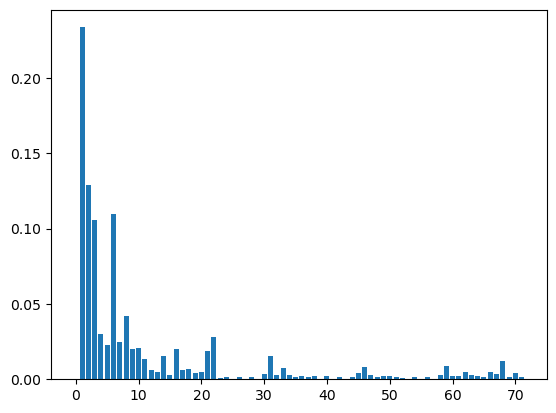

In [34]:
# plot
plt.bar(range(len(xgbc.feature_importances_)), xgbc.feature_importances_)
plt.show()

In [35]:
feature_df = pd.DataFrame(index = [X_train.columns], data = xgbc.feature_importances_)
feature_df.to_csv("features.csv")

In [36]:
feature_df.head(10)

,0
month_num,0.000000
ttl_num_of_cls_in_cur_mth,0.233620
ttl_num_of_opens_in_cur_mth,0.128959
ttl_num_of_mails_sent_in_cur_mth,0.105523
ttl_num_of_cls_in_lst_3_mth,0.029858
ttl_num_of_op_in_lst_3_mth,0.023066
ttl_num_of_mails_snt_in_lst_3_mth,0.109908
ttl_opt_out_num,0.024621
rec_opt_in_days,0.041926
mail_cnt_asn_pr_cust,0.019867


### Decile with XGBC for OSS and OTT

#### Useful functions

In [20]:
def customize_split(number):
    """
    Input
    number: int
    Output
    grp_num: Provides grp_num to which numbers belong between customize percentile [1,3,5,10,20,100].
    """
    if number == 1:
        grp_num = 1
    elif number <=3:
        grp_num = 3
    elif number <=5:
        grp_num = 5
    elif number <=10:
        grp_num = 10
    elif number <=20:
        grp_num = 20
    elif number <=100:
        grp_num = 100
    return grp_num

In [21]:
def calc_lorenze_acc(X:pd.DataFrame(), y:pd.DataFrame(), actual:str, pred_value:str, m, method='gini', num_split=100, cust_split_list = [1,3,5,10,20,100]):
    """
    X : dataframe of testing data
    y : dataframe of target data
    actual : Target col name
    pred_value : prediction col name
    m : trained model name
    method : default to gini
    num_split : number for splitting the data into buckets.
    cust_split_list : customize splitting list.
    If changing the customized percentage list then change the customize_split function accordingly.
    """
    
    df=pd.DataFrame(y.copy())
    df[pred_value]= m.predict_proba(X)[:,1]
    data = df.copy()
    data = data.sort_values(pred_value, ascending=False)
    data['rank'] = range(len(data))
    data['perc_grp'] =data['rank'].apply(lambda x: (math.floor(num_split * x/len(y))+1))
    data['grp'] = data['perc_grp'].apply(lambda x : customize_split(x))

    lorenz = data.groupby('grp')[[pred_value, actual]].mean()
    lorenz['num_mail_id']=data.groupby('grp').size()
    lorenz['actual_not_unsubscribed']=data.groupby('grp')[[actual]].agg(lambda x: x.eq(0).sum())
    lorenz['actual_unsubscribed']=data.groupby('grp')[[actual]].agg(lambda x: x.eq(1).sum())
    lorenz["per_unsubscribed"] = lorenz['actual_unsubscribed']/lorenz['num_mail_id']

    cum_dict = {}
    cum_df = pd.DataFrame()
    for per in cust_split_list:
        temp_dict = {
            "grp" : per,
            "y_pred_xgbc_oot_cum" : data[data["perc_grp"]<=per][[pred_value, actual]].mean()[pred_value],
            "unsubscribe_or_not_cum" : data[data["perc_grp"]<=per][[pred_value, actual]].mean()[actual],
            "num_mail_id_cum" : data[data["perc_grp"]<=per].shape[0],
            "actual_not_unsubscribed_cum" : data[data["perc_grp"]<=per][data[data["perc_grp"]<=per][actual]==0].shape[0],
            "actual_unsubscribed_cum" : data[data["perc_grp"]<=per][data[data["perc_grp"]<=per][actual]==1].shape[0],
            "per_unsubscribed_cum" : data[data["perc_grp"]<=per][data[data["perc_grp"]<=per][actual]==1].shape[0]/data[data["perc_grp"]<=per].shape[0]
        }
        temp_df = pd.DataFrame([temp_dict])
        cum_df = pd.concat([cum_df,temp_df], ignore_index = True)
    cum_df.set_index("grp", drop = True)

    lorenz = pd.merge(lorenz,cum_df,on = "grp")
    total = data[actual].sum()
    y1 = data[[actual, pred_value]].sort_values(pred_value, ascending=False) [actual].cumsum().values/total
    y2 = data[[actual, pred_value]].sort_values(actual, ascending=False)[actual].cumsum().values/total
    x1 = ((2*y1.sum()-y1[-1])/df.shape[0])-1
    x2 = ((2*y2.sum()-y2[-1])/df.shape[0])-1
    gini=x1/x2
    
    return gini, lorenz, data

#### OOS results

In [22]:
gini_oos, lorenz_oos, data_oos = calc_lorenze_acc(X_test, y_test, "unsubscribe_or_not", "y_pred_xgbc_oos", xgbc, method='gini', num_split=100, cust_split_list = [1,3,5,10,20,100])

In [23]:
gini_oos

0.969387151669291

In [24]:
lorenz_oos

,grp,y_pred_xgbc_oos,unsubscribe_or_not,num_mail_id,actual_not_unsubscribed,actual_unsubscribed,per_unsubscribed,y_pred_xgbc_oot_cum,unsubscribe_or_not_cum,num_mail_id_cum,actual_not_unsubscribed_cum,actual_unsubscribed_cum,per_unsubscribed_cum
0,1,0.691905,0.698945,63912,19241,44671,0.698945,0.691905,0.698945,63912,19241,44671,0.698945
1,3,0.059565,0.059425,127824,120228,7596,0.059425,0.270345,0.272599,191736,139469,52267,0.272599
2,5,0.013536,0.012400,127824,126239,1585,0.012400,0.167622,0.168519,319560,265708,53852,0.168519
3,10,0.005368,0.004951,319560,317978,1582,0.004951,0.086495,0.086735,639120,583686,55434,0.086735
4,20,0.002207,0.001906,639120,637902,1218,0.001906,0.044351,0.044320,1278240,1221588,56652,0.044320
5,100,0.000277,0.000268,5112957,5111586,1371,0.000268,0.009092,0.009079,6391197,6333174,58023,0.009079


In [41]:
data_oos[data_oos["perc_grp"]==1][data_oos[data_oos["perc_grp"]==1]["y_pred_xgbc_oos"]>=0.5][data_oos[data_oos["perc_grp"]==1][data_oos[data_oos["perc_grp"]==1]["y_pred_xgbc_oos"]>=0.5]["unsubscribe_or_not"]==1]

,unsubscribe_or_not,y_pred_xgbc_oos,rank,perc_grp,grp
3504165,1,0.999833,0,1,1
4601443,1,0.999770,1,1,1
4129739,1,0.999739,2,1,1
3933825,1,0.999732,3,1,1
3340505,1,0.999730,4,1,1
...,...,...,...,...,...
3177915,1,0.500103,45663,1,1
3038549,1,0.500093,45664,1,1
5642704,1,0.500071,45665,1,1
6280063,1,0.500024,45667,1,1


#### OOT results

In [35]:
gini_oot, lorenz_oot, data_oot = calc_lorenze_acc(X_test_data_OOT, y_test_data_OOT, "unsubscribe_or_not", "y_pred_xgbc_oot", xgbc, method='gini', num_split=100, cust_split_list = [1,3,5,10,20,100])

In [36]:
gini_oot

0.925719585190881

In [37]:
lorenz_oot

,grp,y_pred_xgbc_oot,unsubscribe_or_not,num_mail_id,actual_not_unsubscribed,actual_unsubscribed,per_unsubscribed,y_pred_xgbc_oot_cum,unsubscribe_or_not_cum,num_mail_id_cum,actual_not_unsubscribed_cum,actual_unsubscribed_cum,per_unsubscribed_cum
0,1,0.680155,0.548636,58352,26338,32014,0.548636,0.680155,0.548636,58352,26338,32014,0.548636
1,3,0.205967,0.057050,116704,110046,6658,0.057050,0.364030,0.220912,175056,136384,38672,0.220912
2,5,0.086097,0.022004,116704,114136,2568,0.022004,0.252857,0.141349,291760,250520,41240,0.141349
3,10,0.034855,0.011513,291759,288400,3359,0.011513,0.143856,0.076431,583519,538920,44599,0.076431
4,20,0.009854,0.005457,583519,580335,3184,0.005457,0.076855,0.040944,1167038,1119255,47783,0.040944
5,100,0.000753,0.000602,4668151,4665339,2812,0.000602,0.015973,0.008671,5835189,5784594,50595,0.008671


In [42]:
data_oot[data_oot["perc_grp"]==1][data_oot[data_oot["perc_grp"]==1]["y_pred_xgbc_oot"]>=0.5][data_oot[data_oot["perc_grp"]==1][data_oot[data_oot["perc_grp"]==1]["y_pred_xgbc_oot"]>=0.5]["unsubscribe_or_not"]==1]

,unsubscribe_or_not,y_pred_xgbc_oot,rank,perc_grp,grp
4864406,1,0.999653,0,1,1
4227376,1,0.999544,1,1,1
4113925,1,0.999526,2,1,1
4471613,1,0.999525,3,1,1
3558094,1,0.999405,4,1,1
...,...,...,...,...,...
4694273,1,0.500141,41697,1,1
5029406,1,0.500113,41700,1,1
1100252,1,0.500076,41702,1,1
470976,1,0.500040,41706,1,1


In [61]:
gini_oos1, lorenz_oos1, data_oos1 = calc_lorenze_acc(X_test, y_test, "unsubscribe_or_not", "y_pred_xgbc_oos", xgbc1, method='gini', num_split=100, cust_split_list = [1,3,5,10,20,100])

In [62]:
gini_oot1, lorenz_oot1, data_oot1 = calc_lorenze_acc(X_test_data_OOT, y_test_data_OOT, "unsubscribe_or_not", "y_pred_xgbc_oot", xgbc1, method='gini', num_split=100, cust_split_list = [1,3,5,10,20,100])

In [63]:
gini_oos1

0.970029370613258

In [64]:
lorenz_oos1

,grp,y_pred_xgbc_oos,unsubscribe_or_not,num_mail_id,actual_not_unsubscribed,actual_unsubscribed,per_unsubscribed,y_pred_xgbc_oot_cum,unsubscribe_or_not_cum,num_mail_id_cum,actual_not_unsubscribed_cum,actual_unsubscribed_cum,per_unsubscribed_cum
0,1,0.990961,0.686929,63912,20009,43903,0.686929,0.990961,0.686929,63912,20009,43903,0.686929
1,3,0.824407,0.064996,127824,119516,8308,0.064996,0.879925,0.272307,191736,139525,52211,0.272307
2,5,0.565376,0.013534,127824,126094,1730,0.013534,0.754105,0.168798,319560,265619,53941,0.168798
3,10,0.330867,0.004954,319560,317977,1583,0.004954,0.542486,0.086876,639120,583596,55524,0.086876
4,20,0.164289,0.001976,639120,637857,1263,0.001976,0.353388,0.044426,1278240,1221453,56787,0.044426
5,100,0.022582,0.000242,5112957,5111721,1236,0.000242,0.088743,0.009079,6391197,6333174,58023,0.009079


In [65]:
gini_oot1

0.9307466731100824

In [66]:
lorenz_oot1

,grp,y_pred_xgbc_oot,unsubscribe_or_not,num_mail_id,actual_not_unsubscribed,actual_unsubscribed,per_unsubscribed,y_pred_xgbc_oot_cum,unsubscribe_or_not_cum,num_mail_id_cum,actual_not_unsubscribed_cum,actual_unsubscribed_cum,per_unsubscribed_cum
0,1,0.991070,0.564951,58352,25386,32966,0.564951,0.991070,0.564951,58352,25386,32966,0.564951
1,3,0.935225,0.060092,116704,109691,7013,0.060092,0.953840,0.228378,175056,135077,39979,0.228378
2,5,0.868113,0.016726,116704,114752,1952,0.016726,0.919549,0.143717,291760,249829,41931,0.143717
3,10,0.732364,0.010858,291759,288591,3168,0.010858,0.825957,0.077288,583519,538420,45099,0.077288
4,20,0.445656,0.004894,583519,580663,2856,0.004894,0.635807,0.041091,1167038,1119083,47955,0.041091
5,100,0.057220,0.000566,4668151,4665511,2640,0.000566,0.172938,0.008671,5835189,5784594,50595,0.008671


# For yearly data

## Data Ingestion

In [6]:
# TRAINING DATA
t1 = time.time()

qr1 = '''SELECT * FROM kohls-bda-mkt-prd.dp_marketing_sandbox.TKA1JB1_email_unsubscribe_yearly_data_V3_train_OOT_1'''
training_data = pandas_gbq.read_gbq(qr1,project_id='kohls-bda-mkt-lle',use_bqstorage_api=True)

print(f"Total time taken to read the data : {(time.time()-t1)/60} mins")

Downloading: 100%|██████████|
Total time taken to read the data : 5.034613978862763 mins


## Data Preparation

In [7]:
training_data.shape

(23195416, 76)

In [8]:
pd.set_option('display.max_columns', None)
training_data.head(2)

,email_addr,vantage_date,month_num,ttl_num_of_cls_in_cur_mth,ttl_num_of_opens_in_cur_mth,ttl_num_of_mails_sent_in_cur_mth,ttl_num_of_cls_in_lst_3_mth,ttl_num_of_op_in_lst_3_mth,ttl_num_of_mails_snt_in_lst_3_mth,cust_id,ttl_opt_out_num,rec_opt_in_days,mail_cnt_asn_pr_cust,total_trip_cnt,months_to_last_trans,cust_age,med_incm,kc_holder,dist_to_store,lst_qrt_trp_cnt,lst_qrt_pur_qnts,lst_qrt_spt_amt,lst_qrt_dis_qnt,lst_qrt_dis_spt_amt,lst_qrt_pur_qnts_wt_kc_card,lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_lst_qrt,BEAUTY_trans_pur_amt_for_lst_qrt,CHILDRENS_trans_pur_amt_for_lst_qrt,HOME_trans_pur_amt_for_lst_qrt,MENS_trans_pur_amt_for_lst_qrt,WOMENS_trans_pur_amt_for_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_lst_qrt,sec_lst_qrt_trp_cnt,sec_lst_qrt_pur_qnts,sec_lst_qrt_spt_amt,sec_lst_qrt_dis_qnt,sec_lst_qrt_dis_spt_amt,sec_lst_qrt_pur_qnts_wt_kc_card,sec_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_sec_lst_qrt,BEAUTY_trans_pur_amt_for_sec_lst_qrt,CHILDRENS_trans_pur_amt_for_sec_lst_qrt,HOME_trans_pur_amt_for_sec_lst_qrt,MENS_trans_pur_amt_for_sec_lst_qrt,WOMENS_trans_pur_amt_for_sec_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_sec_lst_qrt,trd_lst_qrt_trp_cnt,trd_lst_qrt_pur_qnts,trd_lst_qrt_spt_amt,trd_lst_qrt_dis_qnt,trd_lst_qrt_dis_spt_amt,trd_lst_qrt_pur_qnts_wt_kc_card,trd_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_trd_lst_qrt,BEAUTY_trans_pur_amt_for_trd_lst_qrt,CHILDRENS_trans_pur_amt_for_trd_lst_qrt,HOME_trans_pur_amt_for_trd_lst_qrt,MENS_trans_pur_amt_for_trd_lst_qrt,WOMENS_trans_pur_amt_for_trd_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_trd_lst_qrt,frt_lst_qrt_trp_cnt,frt_lst_qrt_pur_qnts,frt_lst_qrt_spt_amt,frt_lst_qrt_dis_qnt,frt_lst_qrt_dis_spt_amt,frt_lst_qrt_pur_qnts_wt_kc_card,frt_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_frt_lst_qrt,BEAUTY_trans_pur_amt_for_frt_lst_qrt,CHILDRENS_trans_pur_amt_for_frt_lst_qrt,HOME_trans_pur_amt_for_frt_lst_qrt,MENS_trans_pur_amt_for_frt_lst_qrt,WOMENS_trans_pur_amt_for_frt_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_frt_lst_qrt,unsubscribe_or_not
0,aMPLFLnS@WOLd8.6o4,2022-12-01,12,0,37,60,1,179,176,143247512,2,1507,1,358,1,69,125000,1,1.632264107,28,30,771.560000000,20,352.110000000,26,595.560000000,283.070000000,0E-9,0E-9,190.250000000,0E-9,71.410000000,0E-9,22,23,256.970000000,21,198.980000000,23,256.970000000,16.600000000,0E-9,0E-9,0E-9,0E-9,72.800000000,0E-9,25,25,542.280000000,20,349.820000000,25,542.280000000,183.590000000,0E-9,0E-9,91.570000000,77.270000000,87.970000000,8.390000000,15,16,284.300000000,12,181.320000000,14,284.300000000,39.990000000,0E-9,0E-9,15.750000000,114.000000000,51.570000000,0E-9,0
1,uUwkGIrn@GMiTb.6Mz,2022-06-01,6,0,0,1,0,0,0,1123702941,8,183,2,28,7,37,<NA>,0,11.032493648,0,0,0E-9,0,0E-9,0,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,9,9,21.140000000,7,16.320000000,0,0E-9,2.310000000,0E-9,12.110000000,4.200000000,0E-9,0E-9,0E-9,23,23,720.140000000,9,84.920000000,0,0E-9,35.230000000,0E-9,227.440000000,365.970000000,56.250000000,0E-9,0E-9,5,5,129.450000000,5,129.450000000,0,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,67.370000000,0


In [9]:
for col in col_to_convert_float_ls:
    training_data[col] = training_data[col].astype(float)

In [13]:
X_train_y = training_data.drop(columns = ["email_addr", "vantage_date", "cust_id", "unsubscribe_or_not"], axis = 1)
y_train_y = training_data['unsubscribe_or_not'].astype(int)
del training_data

In [14]:
collected_objects = gc.collect()

In [15]:
X_train_y.shape, y_train_y.shape

((23195416, 72), (23195416,))

## Model Training

### XGBC

In [16]:
# TRAINING
t1 = time.time()

xgbc_y  =XGBClassifier()
xgbc_y.fit(X_train_y,y_train_y)

print(f"Total time taken to train the model : {(time.time()-t1)/60} mins")

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

### Testing on OOS data

In [29]:
# TESTING DATA OOS
t1 = time.time()

qr2 = '''SELECT * FROM kohls-bda-mkt-prd.dp_marketing_sandbox.TKA1JB1_email_unsubscribe_yearly_data_V3_test_OOT_1'''
testing_data = pandas_gbq.read_gbq(qr2,project_id='kohls-bda-mkt-lle',use_bqstorage_api=True)

print(f"Total time taken to read the data : {(time.time()-t1)/60} mins")

Downloading: 100%|██████████|
Total time taken to read the data : 1.561493961016337 mins


In [30]:
pd.set_option('display.max_columns', None)
testing_data.head(2)

,email_addr,vantage_date,month_num,ttl_num_of_cls_in_cur_mth,ttl_num_of_opens_in_cur_mth,ttl_num_of_mails_sent_in_cur_mth,ttl_num_of_cls_in_lst_3_mth,ttl_num_of_op_in_lst_3_mth,ttl_num_of_mails_snt_in_lst_3_mth,cust_id,ttl_opt_out_num,rec_opt_in_days,mail_cnt_asn_pr_cust,total_trip_cnt,months_to_last_trans,cust_age,med_incm,kc_holder,dist_to_store,lst_qrt_trp_cnt,lst_qrt_pur_qnts,lst_qrt_spt_amt,lst_qrt_dis_qnt,lst_qrt_dis_spt_amt,lst_qrt_pur_qnts_wt_kc_card,lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_lst_qrt,BEAUTY_trans_pur_amt_for_lst_qrt,CHILDRENS_trans_pur_amt_for_lst_qrt,HOME_trans_pur_amt_for_lst_qrt,MENS_trans_pur_amt_for_lst_qrt,WOMENS_trans_pur_amt_for_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_lst_qrt,sec_lst_qrt_trp_cnt,sec_lst_qrt_pur_qnts,sec_lst_qrt_spt_amt,sec_lst_qrt_dis_qnt,sec_lst_qrt_dis_spt_amt,sec_lst_qrt_pur_qnts_wt_kc_card,sec_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_sec_lst_qrt,BEAUTY_trans_pur_amt_for_sec_lst_qrt,CHILDRENS_trans_pur_amt_for_sec_lst_qrt,HOME_trans_pur_amt_for_sec_lst_qrt,MENS_trans_pur_amt_for_sec_lst_qrt,WOMENS_trans_pur_amt_for_sec_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_sec_lst_qrt,trd_lst_qrt_trp_cnt,trd_lst_qrt_pur_qnts,trd_lst_qrt_spt_amt,trd_lst_qrt_dis_qnt,trd_lst_qrt_dis_spt_amt,trd_lst_qrt_pur_qnts_wt_kc_card,trd_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_trd_lst_qrt,BEAUTY_trans_pur_amt_for_trd_lst_qrt,CHILDRENS_trans_pur_amt_for_trd_lst_qrt,HOME_trans_pur_amt_for_trd_lst_qrt,MENS_trans_pur_amt_for_trd_lst_qrt,WOMENS_trans_pur_amt_for_trd_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_trd_lst_qrt,frt_lst_qrt_trp_cnt,frt_lst_qrt_pur_qnts,frt_lst_qrt_spt_amt,frt_lst_qrt_dis_qnt,frt_lst_qrt_dis_spt_amt,frt_lst_qrt_pur_qnts_wt_kc_card,frt_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_frt_lst_qrt,BEAUTY_trans_pur_amt_for_frt_lst_qrt,CHILDRENS_trans_pur_amt_for_frt_lst_qrt,HOME_trans_pur_amt_for_frt_lst_qrt,MENS_trans_pur_amt_for_frt_lst_qrt,WOMENS_trans_pur_amt_for_frt_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_frt_lst_qrt,unsubscribe_or_not
0,bWZWfjfzAcYJ@KUumvhG.3tJ,2022-05-01,5,0,7,52,0,4,131,18636910,2,767,19,600,1,49,125000,1,3.235229130,351,366,4664.370000000,315,3143.370000000,204,3070.260000000,633.990000000,0E-9,636.540000000,45.000000000,83.940000000,648.390000000,532.260000000,276,327,4632.960000000,213,3010.710000000,132,2047.740000000,1060.920000000,642.660000000,204.870000000,468.540000000,620.940000000,391.830000000,340.470000000,123,159,2888.760000000,150,2681.250000000,144,2827.170000000,326.040000000,0E-9,0E-9,2071.140000000,0E-9,263.700000000,59.370000000,189,237,3108.750000000,222,2819.250000000,210,2685.810000000,208.500000000,0E-9,0E-9,523.320000000,652.560000000,1012.680000000,150.000000000,0
1,XfSu4y4abOA@6fE5U.78Z,2022-11-01,11,0,11,64,2,30,140,506829547,3,1046,1,37,5,45,47500,1,6.131198491,4,5,182.600000000,4,107.600000000,5,182.600000000,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,20,20,363.890000000,17,255.070000000,20,363.890000000,15.990000000,0E-9,0E-9,0E-9,0E-9,223.320000000,0E-9,9,10,321.240000000,2,90.000000000,10,321.240000000,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,8,8,173.490000000,2,62.990000000,8,173.490000000,100.000000000,0E-9,28.500000000,0E-9,0E-9,0E-9,0E-9,0


In [31]:
testing_data.shape

(7731794, 76)

In [32]:
for col in col_to_convert_float_ls:
    testing_data[col] = testing_data[col].astype(float)

In [33]:
X_test_y = testing_data.drop(columns = ["email_addr", "vantage_date", "cust_id", "unsubscribe_or_not"], axis = 1)
y_test_y = testing_data['unsubscribe_or_not'].astype(int)
del testing_data

In [34]:
collected_objects = gc.collect()

In [35]:
X_test_y.shape, y_test_y.shape

((7731794, 72), (7731794,))

In [36]:
y_pred_xgbc_y = xgbc_y.predict(X_test_y)

In [37]:
print(accuracy_score(y_test_y,y_pred_xgbc_y),
precision_score(y_test_y,y_pred_xgbc_y),
recall_score(y_test_y,y_pred_xgbc_y),
f1_score(y_test_y,y_pred_xgbc_y))

0.9913254284839974 0.8248572174722667 0.5844831886460001 0.6841713677588269


### Testing on OOT data

In [38]:
t1 = time.time()
qr = '''SELECT * FROM kohls-bda-mkt-prd.dp_marketing_sandbox.KA1JB1_email_unsubscribe_feb_v1_OOT_1'''
data_OOT= pandas_gbq.read_gbq(qr,project_id='kohls-bda-mkt-lle',use_bqstorage_api=True)
print(f"Total time taken to read the data : {(time.time()-t1)/60} mins")

Downloading: 100%|██████████|
Total time taken to read the data : 1.5068091948827107 mins


In [39]:
data_OOT.shape

(5835189, 76)

In [40]:
for col in col_to_convert_float_ls:
    data_OOT[col] = data_OOT[col].astype(float)

In [41]:
data_OOT.head()

,email_addr,vantage_date,month_num,ttl_num_of_cls_in_cur_mth,ttl_num_of_opens_in_cur_mth,ttl_num_of_mails_sent_in_cur_mth,ttl_num_of_cls_in_lst_3_mth,ttl_num_of_op_in_lst_3_mth,ttl_num_of_mails_snt_in_lst_3_mth,cust_id,ttl_opt_out_num,rec_opt_in_days,mail_cnt_asn_pr_cust,total_trip_cnt,months_to_last_trans,cust_age,med_incm,kc_holder,dist_to_store,lst_qrt_trp_cnt,lst_qrt_pur_qnts,lst_qrt_spt_amt,lst_qrt_dis_qnt,lst_qrt_dis_spt_amt,lst_qrt_pur_qnts_wt_kc_card,lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_lst_qrt,BEAUTY_trans_pur_amt_for_lst_qrt,CHILDRENS_trans_pur_amt_for_lst_qrt,HOME_trans_pur_amt_for_lst_qrt,MENS_trans_pur_amt_for_lst_qrt,WOMENS_trans_pur_amt_for_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_lst_qrt,sec_lst_qrt_trp_cnt,sec_lst_qrt_pur_qnts,sec_lst_qrt_spt_amt,sec_lst_qrt_dis_qnt,sec_lst_qrt_dis_spt_amt,sec_lst_qrt_pur_qnts_wt_kc_card,sec_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_sec_lst_qrt,BEAUTY_trans_pur_amt_for_sec_lst_qrt,CHILDRENS_trans_pur_amt_for_sec_lst_qrt,HOME_trans_pur_amt_for_sec_lst_qrt,MENS_trans_pur_amt_for_sec_lst_qrt,WOMENS_trans_pur_amt_for_sec_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_sec_lst_qrt,trd_lst_qrt_trp_cnt,trd_lst_qrt_pur_qnts,trd_lst_qrt_spt_amt,trd_lst_qrt_dis_qnt,trd_lst_qrt_dis_spt_amt,trd_lst_qrt_pur_qnts_wt_kc_card,trd_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_trd_lst_qrt,BEAUTY_trans_pur_amt_for_trd_lst_qrt,CHILDRENS_trans_pur_amt_for_trd_lst_qrt,HOME_trans_pur_amt_for_trd_lst_qrt,MENS_trans_pur_amt_for_trd_lst_qrt,WOMENS_trans_pur_amt_for_trd_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_trd_lst_qrt,frt_lst_qrt_trp_cnt,frt_lst_qrt_pur_qnts,frt_lst_qrt_spt_amt,frt_lst_qrt_dis_qnt,frt_lst_qrt_dis_spt_amt,frt_lst_qrt_pur_qnts_wt_kc_card,frt_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_frt_lst_qrt,BEAUTY_trans_pur_amt_for_frt_lst_qrt,CHILDRENS_trans_pur_amt_for_frt_lst_qrt,HOME_trans_pur_amt_for_frt_lst_qrt,MENS_trans_pur_amt_for_frt_lst_qrt,WOMENS_trans_pur_amt_for_frt_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_frt_lst_qrt,unsubscribe_or_not
0,4O2TrcP@ILN.Lbx,2023-02-01,2,0,1,39,1,9,181,91357560,<NA>,786,1,165,5,64,87500,1,3.106394,0,0,0.00,0,0.00,0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,43,43,793.35,24,366.21,43,793.35,293.15,0.0,0.0,0.00,0.0,190.31,0.0,7,7,100.75,7,100.75,7,100.75,0.0,0.0,0.0,0.00,0.0,100.75,0.0,0,0,0.00,0,0.00,0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0
1,xz8cCbT@aT4pszuy5.dmZ,2023-02-01,2,0,16,40,0,92,158,139265580,<NA>,134,2,58,2,68,250000,1,1.473449,11,12,207.54,12,207.54,12,207.54,22.10,0.0,0.0,31.18,0.0,61.20,0.0,58,59,686.50,59,686.50,57,674.20,157.91,0.0,0.0,60.40,0.0,0.00,0.0,8,8,58.62,8,58.62,8,58.62,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0,0,0.00,0,0.00,0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0
2,15Uyxbj5zAC@eOfks.p10,2023-02-01,2,0,0,28,0,0,136,605876474,3,1138,5,58,1,30,<NA>,1,1.773114,51,52,793.61,30,319.65,34,697.99,162.80,0.0,0.0,189.74,0.0,56.30,0.0,32,32,875.23,25,684.00,32,875.23,488.49,0.0,0.0,6.24,0.0,145.08,0.0,13,13,155.39,11,113.39,13,155.39,37.0,0.0,0.0,0.00,0.0,54.61,0.0,22,23,363.37,22,337.38,10,191.07,50.07,0.0,0.0,49.96,8.99,133.80,0.0,0
3,xJzpesjbsdSTMF@KvQv2.EFR,2023-02-01,2,0,43,42,1,231,186,1055115025,1,506,1,35,2,25,<NA>,0,1.279884,35,35,460.64,23,198.55,0,0.00,40.27,0.0,0.0,136.22,0.0,27.21,0.0,33,33,334.43,31,316.21,0,0.00,0.00,0.0,0.0,7.60,0.0,161.36,0.0,24,27,251.35,12,125.33,0,0.00,0.0,0.0,0.0,85.52,0.0,65.80,0.0,5,5,104.55,5,104.55,0,0.00,0.00,0.0,0.0,0.00,0.00,62.16,14.4,0
4,1xdEazHGT@W5diq.0Fn,2023-02-01,2,0,42,41,5,175,177,30183227,1,509,3,219,2,65,57500,1,4.367002,13,13,195.21,10,119.24,13,195.21,75.97,0.0,0.0,12.41,0.0,97.73,0.0,19,23,229.49,22,218.99,23,229.49,35.97,0.0,0.0,62.78,0.0,66.94,0.0,34,35,457.94,32,391.30,18,287.68,0.0,0.0,0.0,10.39,0.0,191.25,0.0,10,10,191.10,9,141.90,10,191.10,0.00,0.0,0.0,0.00,0.00,42.90,99.0,0


In [42]:
X_test_data_OOT = data_OOT.drop(columns = ["email_addr", "vantage_date", "cust_id", "unsubscribe_or_not"], axis = 1)
y_test_data_OOT = data_OOT['unsubscribe_or_not'].astype(int)
del data_OOT

In [43]:
collected_objects = gc.collect()

In [44]:
X_test_data_OOT.shape, y_test_data_OOT.shape

((5835189, 72), (5835189,))

In [45]:
y_pred_xgbc_y_oot = xgbc_y.predict(X_test_data_OOT)

In [46]:
print(accuracy_score(y_test_data_OOT,y_pred_xgbc_y_oot),
precision_score(y_test_data_OOT,y_pred_xgbc_y_oot),
recall_score(y_test_data_OOT,y_pred_xgbc_y_oot),
f1_score(y_test_data_OOT,y_pred_xgbc_y_oot))

0.9913248739672357 0.4368932038834951 0.0017788319003854136 0.0035432373378476802


In [47]:
confusion_matrix(y_test_data_OOT,y_pred_xgbc_y_oot)

array([[5784478,     116],
       [  50505,      90]])

### Decile with XGBC for OSS and OTT

In [48]:
gini_oos_y, lorenz_oos_y, data_oos_y = calc_lorenze_acc(X_test_y, y_test_y, "unsubscribe_or_not", "y_pred_xgbc_y_oos", xgbc_y, method='gini', num_split=100, cust_split_list = [1,3,5,10,20,100])

In [49]:
gini_oos_y

0.9598628135615443

In [50]:
lorenz_oos_y

,grp,y_pred_xgbc_y_oos,unsubscribe_or_not,num_mail_id,actual_not_unsubscribed,actual_unsubscribed,per_unsubscribed,y_pred_xgbc_oot_cum,unsubscribe_or_not_cum,num_mail_id_cum,actual_not_unsubscribed_cum,actual_unsubscribed_cum,per_unsubscribed_cum
0,1,0.843878,0.860990,77318,10748,66570,0.860990,0.843878,0.860990,77318,10748,66570,0.860990
1,3,0.222870,0.229352,154636,119170,35466,0.229352,0.429873,0.439898,231954,129918,102036,0.439898
2,5,0.053538,0.050726,154636,146792,7844,0.050726,0.279339,0.284229,386590,276710,109880,0.284229
3,10,0.019700,0.018273,386590,379526,7064,0.018273,0.149520,0.151251,773180,656236,116944,0.151251
4,20,0.006296,0.005188,773179,769168,4011,0.005188,0.077908,0.078219,1546359,1425404,120955,0.078219
5,100,0.000666,0.000539,6185435,6182099,3336,0.000539,0.016114,0.016075,7731794,7607503,124291,0.016075


In [51]:
data_oos_y

,unsubscribe_or_not,y_pred_xgbc_y_oos,rank,perc_grp,grp
5100393,1,9.995127e-01,0,1,1
4833230,1,9.992504e-01,1,1,1
5618757,1,9.992225e-01,2,1,1
4824810,1,9.991762e-01,3,1,1
5658270,1,9.990247e-01,4,1,1
...,...,...,...,...,...
6756312,0,7.670974e-07,7731789,100,100
227332,0,6.790004e-07,7731790,100,100
5657748,0,4.552790e-07,7731791,100,100
126354,0,4.211578e-07,7731792,100,100


In [52]:
gini_oot_y, lorenz_oot_y, data_oot_y = calc_lorenze_acc(X_test_data_OOT, y_test_data_OOT, "unsubscribe_or_not", "y_pred_xgbc_y_oot", xgbc_y, method='gini', num_split=100, cust_split_list = [1,3,5,10,20,100])

In [53]:
gini_oot_y

0.9063353805724457

In [54]:
lorenz_oot_y

,grp,y_pred_xgbc_y_oot,unsubscribe_or_not,num_mail_id,actual_not_unsubscribed,actual_unsubscribed,per_unsubscribed,y_pred_xgbc_oot_cum,unsubscribe_or_not_cum,num_mail_id_cum,actual_not_unsubscribed_cum,actual_unsubscribed_cum,per_unsubscribed_cum
0,1,0.086004,0.203523,58352,46476,11876,0.203523,0.086004,0.203523,58352,46476,11876,0.203523
1,3,0.018745,0.151974,116704,98968,17736,0.151974,0.041165,0.169157,175056,145444,29612,0.169157
2,5,0.005366,0.067050,116704,108879,7825,0.067050,0.026845,0.128314,291760,254323,37437,0.128314
3,10,0.001675,0.024160,291759,284710,7049,0.024160,0.014260,0.076237,583519,539033,44486,0.076237
4,20,0.000498,0.006999,583519,579435,4084,0.006999,0.007379,0.041618,1167038,1118468,48570,0.041618
5,100,0.000072,0.000434,4668151,4666126,2025,0.000434,0.001533,0.008671,5835189,5784594,50595,0.008671


In [55]:
data_oot_y

,unsubscribe_or_not,y_pred_xgbc_y_oot,rank,perc_grp,grp
5173705,1,6.982271e-01,0,1,1
1872719,1,6.935795e-01,1,1,1
1996506,1,6.618983e-01,2,1,1
2699739,0,6.366653e-01,3,1,1
5788108,1,6.081663e-01,4,1,1
...,...,...,...,...,...
3625557,0,2.795554e-07,5835184,100,100
465236,0,2.472431e-07,5835185,100,100
3095644,0,2.374535e-07,5835186,100,100
5241458,0,1.791508e-07,5835187,100,100
